<a href="https://colab.research.google.com/github/hck717/Ichimoku-Fibonacci-Strategy/blob/main/Ichimoku_Fibonacci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the TA-Lib C library
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0
!./configure --prefix=/usr
!make
!make install
%cd ..

# Then install the Python wrapper
!pip install ta-lib



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--2025-10-31 06:37:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-10-31 06:37:23--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

/tmp/ipython-input-396462476.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


=== Debug Values ===
Latest Close: 109622.0
SSA last valid: 117244.029296875
SSB last valid: 116415.1953125

=== Analysis ===
Trend: Bearish
Swing Low: 74436.68, Swing High: 126198.07
Fib Levels: {'0.236': 113982.382125, '0.382': 106425.21909375, '0.5': 100317.375, '0.618': 94209.53090625, '0.786': 85513.61728125}
Preferred Entry Zone: 106425.22 – 94209.53
Stop: 126198.07


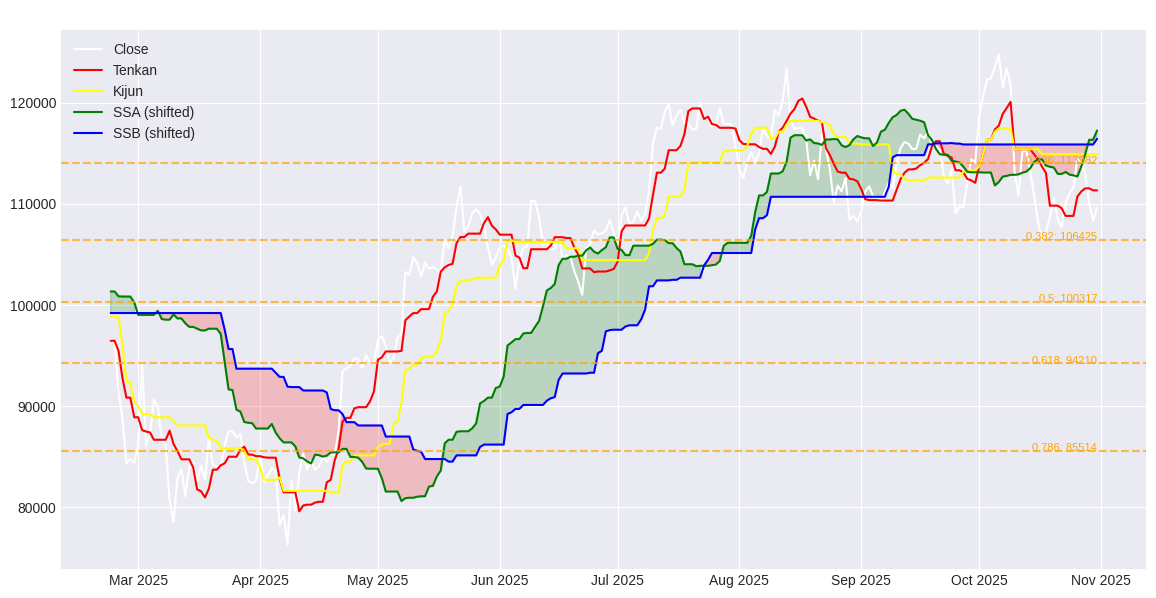

Tenkan head: [           nan            nan            nan            nan
            nan            nan            nan            nan
 14573.29882812 14573.29882812 14573.29882812 14620.85107422
 14942.73779297 15282.63330078 15443.19042969 15443.19042969
 15780.14599609 16324.22460938 16759.45458984 16841.97802734
 17153.99902344 17342.90722656 17342.90722656 17365.07763672
 17614.48876953 17977.75488281 17871.         17871.
 17871.         17871.        ]
Kijun head: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 16317.0625     16317.0625     16317.0625
 16358.203125   16485.71826172]
SSA (unshifted) head: [           nan            nan            nan  

In [ ]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Download 2 years of BTC data (daily)
# -----------------------------
df = yf.download("BTC-USD", period="5y", interval="1d")
df.dropna(inplace=True)

# -----------------------------
# Prepare arrays for TA-Lib (must be 1D float arrays)
# -----------------------------
high = df['High'].astype(float).values.flatten()
low = df['Low'].astype(float).values.flatten()
close = df['Close'].astype(float).values.flatten()

# -----------------------------
# Ichimoku components
# -----------------------------
tenkan = (ta.MAX(high, timeperiod=9) + ta.MIN(low, timeperiod=9)) / 2
kijun = (ta.MAX(high, timeperiod=26) + ta.MIN(low, timeperiod=26)) / 2
ssa = (tenkan + kijun) / 2
ssb = (ta.MAX(high, timeperiod=52) + ta.MIN(low, timeperiod=52)) / 2
chikou = np.concatenate([close[26:], np.full(26, np.nan)])  # lagging span

df['Tenkan'] = tenkan
df['Kijun'] = kijun
# ✅ FIX: align with df.index before shifting
df['SSA'] = pd.Series(ssa, index=df.index).shift(26)
df['SSB'] = pd.Series(ssb, index=df.index).shift(26)
df['Chikou'] = pd.Series(chikou, index=df.index)

# -----------------------------
# Slice to last 1 year for plotting/analysis
# -----------------------------
df_last = df.iloc[-252:]  # ~252 trading days ≈ 1 year

# -----------------------------
# Fibonacci retracement (last 1y swing)
# -----------------------------
swing_low = df_last['Low'].min().item()
swing_high = df_last['High'].max().item()

fib_levels = {
    '0.236': swing_high - (swing_high - swing_low) * 0.236,
    '0.382': swing_high - (swing_high - swing_low) * 0.382,
    '0.5':   swing_high - (swing_high - swing_low) * 0.5,
    '0.618': swing_high - (swing_high - swing_low) * 0.618,
    '0.786': swing_high - (swing_high - swing_low) * 0.786,
}

# -----------------------------
# Trend regime check (use last valid SSA/SSB)
# -----------------------------
latest_close = df_last['Close'].iloc[-1].item()

ssa_series = df['SSA'].dropna()
ssb_series = df['SSB'].dropna()

if not ssa_series.empty and not ssb_series.empty:
    ssa_val = float(ssa_series.iloc[-1])
    ssb_val = float(ssb_series.iloc[-1])
    cloud_top = max(ssa_val, ssb_val)
    cloud_bot = min(ssa_val, ssb_val)

    if latest_close > cloud_top:
        trend = "Bullish"
        entry_zone = (fib_levels['0.382'], fib_levels['0.618'])
        stop = swing_low
    elif latest_close < cloud_bot:
        trend = "Bearish"
        entry_zone = (fib_levels['0.382'], fib_levels['0.618'])
        stop = swing_high
    else:
        trend = "Neutral (inside cloud)"
        entry_zone = None
        stop = None
else:
    trend = "Not enough data for Ichimoku Cloud"
    entry_zone = None
    stop = None

print("=== Debug Values ===")
print("Latest Close:", latest_close)
print("SSA last valid:", ssa_val if not ssa_series.empty else "None")
print("SSB last valid:", ssb_val if not ssb_series.empty else "None")

print("\n=== Analysis ===")
print(f"Trend: {trend}")
print(f"Swing Low: {swing_low:.2f}, Swing High: {swing_high:.2f}")
print("Fib Levels:", fib_levels)
if entry_zone:
    print(f"Preferred Entry Zone: {entry_zone[0]:.2f} – {entry_zone[1]:.2f}")
    print(f"Stop: {stop:.2f}")

# -----------------------------
# Plot chart (last 1 year)
# -----------------------------
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(df_last.index, df_last['Close'], color='white', label='Close')
ax.plot(df_last.index, df_last['Tenkan'], color='red', label='Tenkan')
ax.plot(df_last.index, df_last['Kijun'], color='yellow', label='Kijun')
ax.plot(df_last.index, df_last['SSA'], color='green', label='SSA (shifted)')
ax.plot(df_last.index, df_last['SSB'], color='blue', label='SSB (shifted)')
ax.fill_between(df_last.index, df_last['SSA'], df_last['SSB'],
                where=df_last['SSA']>=df_last['SSB'], color='green', alpha=0.2)
ax.fill_between(df_last.index, df_last['SSA'], df_last['SSB'],
                where=df_last['SSA']<df_last['SSB'], color='red', alpha=0.2)

# Fib levels
for k,v in fib_levels.items():
    ax.axhline(v, linestyle='--', color='orange', alpha=0.7)
    ax.text(df_last.index[-1], v, f"{k}: {v:.0f}", color='orange', fontsize=8, ha='right')

ax.set_title("BTC-USD Ichimoku + Fibonacci (Last 1Y, with 2Y history)", color='white')
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()


print("Tenkan head:", tenkan[:30])
print("Kijun head:", kijun[:30])
print("SSA (unshifted) head:", ssa[:30])
print("SSB (unshifted) head:", ssb[:30])

print("Tenkan tail:", tenkan[-30:])
print("Kijun tail:", kijun[-30:])
print("SSA (unshifted) tail:", ssa[-30:])
print("SSB (unshifted) tail:", ssb[-30:])

print("SSA shifted tail:", df['SSA'].tail(30))
print("SSB shifted tail:", df['SSB'].tail(30))




# 📊 How to Read the BTC-USD Ichimoku + Fibonacci Chart

This chart combines **Ichimoku Cloud** analysis with **Fibonacci retracement levels** to help identify trend direction, support/resistance, and potential trade zones.

---

## 🟢 Ichimoku Cloud Components

- **Tenkan-sen (Conversion Line, red)**  
  - Short-term trend (9 periods).  
  - Steeper slope = stronger short-term momentum.

- **Kijun-sen (Base Line, yellow)**  
  - Medium-term trend (26 periods).  
  - Often acts as support/resistance.  
  - Crossovers with Tenkan can signal momentum shifts.

- **Senkou Span A (SSA, green)**  
  - Leading line, average of Tenkan & Kijun, shifted 26 periods forward.  
  - Forms one edge of the cloud.

- **Senkou Span B (SSB, blue)**  
  - Leading line, 52-period high/low midpoint, shifted 26 periods forward.  
  - Forms the other edge of the cloud.

- **Kumo (Cloud fill)**  
  - Green cloud = bullish (SSA above SSB).  
  - Red cloud = bearish (SSA below SSB).  
  - Price **above cloud** = bullish trend.  
  - Price **below cloud** = bearish trend.  
  - Price **inside cloud** = neutral / consolidation.

---

## 🔢 Fibonacci Retracement Levels (orange dashed lines)

- Calculated from the **swing high** and **swing low** of the last year.  
- Key levels: **0.236, 0.382, 0.5, 0.618, 0.786**.  
- These act as potential **support/resistance zones**.  
- Traders often look for entries around **0.382–0.618 retracement**.

---

## 🧭 How to Interpret

1. **Trend Direction**  
   - Price above cloud → bullish bias.  
   - Price below cloud → bearish bias.  
   - Price inside cloud → neutral / indecision.

2. **Entry Zones**  
   - In a bullish trend: look for pullbacks into 0.382–0.618 Fib zone as potential buys.  
   - In a bearish trend: look for rallies into 0.382–0.618 Fib zone as potential shorts.

3. **Stop Placement**  
   - Bullish setups: stop below swing low.  
   - Bearish setups: stop above swing high.

4. **Confluence**  
   - Strong signals occur when **Fib levels align with Ichimoku levels** (Kijun, SSA, SSB).

---

## ⚠️ Notes

- The Ichimoku Cloud is **forward-shifted**, so the last 26 candles may show NaN values in the data but still plot correctly.  
- Always confirm signals with volume, candlestick patterns, or other indicators.  
- This chart is for **educational purposes only**, not financial advice.


Robust strategy